In [ ]:
import numpy as np 
import pandas as pd 
from fastai.vision import *
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
import os
import gc

In [ ]:
path = Path('/content/drive/My Drive/data/plant_pathology/')

In [ ]:
train_df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv(path/'test.csv')
sample_df = pd.read_csv(path/'sample_submission.csv')

In [ ]:
test_df['image_id'] = 'images/' + test_df['image_id'] + '.jpg'

In [ ]:
test_df.head()

,image_id
0,images/Test_0.jpg
1,images/Test_1.jpg
2,images/Test_2.jpg
3,images/Test_3.jpg
4,images/Test_4.jpg


In [ ]:
test_data = ImageList.from_df(test_df, path)

In [ ]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05)

In [ ]:
src = (ImageImageList.from_csv(path,'train.csv', folder='images', suffix='.jpg')
              .split_by_rand_pct(0.2)
              .label_from_df(cols=[1,2,3,4])
              .add_test(test_data))

In [ ]:
train_data = (src
              .transform(tfms, size=(64,64))
              .databunch()
              .normalize(imagenet_stats))

In [ ]:
learn = cnn_learner(train_data, models.densenet161, metrics=[accuracy], wd=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-02
Min loss divided by 10: 1.45E-02


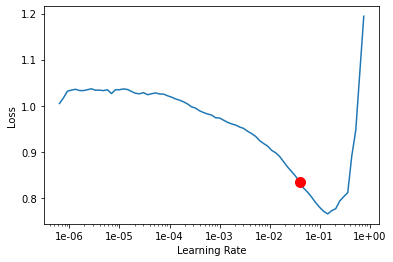

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(30, max_lr=slice(1e-1, 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.859331,0.727768,0.221841,03:32
1,0.713528,0.589579,0.239698,01:42
2,0.613098,0.488567,0.103709,01:42
3,0.493572,0.301848,0.201923,01:40
4,0.416184,0.389334,0.414148,01:40
5,0.353074,0.359871,0.286401,01:41
6,0.323339,0.277613,0.239011,01:40
7,0.298289,0.340390,0.302885,01:40
8,0.291441,0.621646,0.195742,01:41
9,0.280763,1.418615,0.043269,01:40


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.37E-05
Min loss divided by 10: 6.31E-08


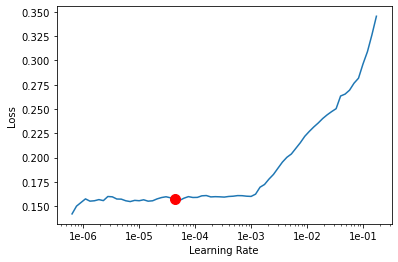

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(30,max_lr=slice(1e-05, 1e-04))

epoch,train_loss,valid_loss,accuracy,time
0,0.150900,0.191337,0.230769,01:40
1,0.152202,0.191547,0.228709,01:40
2,0.149204,0.189810,0.226648,01:41
3,0.146081,0.189219,0.228709,01:42
4,0.149075,0.189559,0.229396,01:41
5,0.152551,0.191291,0.225275,01:41
6,0.152948,0.189823,0.225962,01:40
7,0.151539,0.190688,0.229396,01:41
8,0.150584,0.191521,0.218407,01:42
9,0.149193,0.192944,0.229396,01:41


In [ ]:
preds, y = learn.get_preds(DatasetType.Test)

In [ ]:
sample_df.iloc[:,1:] = preds.numpy()


In [ ]:
sample_df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.000671,0.001863,0.998592,0.002239
1,Test_1,0.000759,0.003946,0.425634,0.717610
2,Test_2,0.009681,0.005919,0.011024,0.982933
3,Test_3,0.987263,0.005671,0.005576,0.007952
4,Test_4,0.000436,0.039346,0.972689,0.004515


In [ ]:
sample_df.to_csv(path/'submission_Densenet161_fastai.csv', index=False)
#Score 87.96%